# Benchmark Testing Pre-Processing Methods: PCA

In this notebook, I will try to perform some benchmark test on different classifiers with PCA.

The procedure: <br>
**Load images - Grayscale - Center - Pre-Processing 1: PCA & Component Extraction - Fit to Classifiers**

Classifiers to be tested:
- Logistic Regression
- kNN
- Decision Tree
- SVM
- CNN

In [1]:
# To modularise the program, we need to add the current directory to sys path
import os
import sys

# Navigate to where our modules are stored
os.chdir('/Users/gardar/Documents/UCL/ELEC0134 MLS-I Applied Machine Learning Systems/Assignments/Final/code')

# Now we can import our own modules into our script.
import import_data as ds
import split_dataset as sd 
import pre_processing as prp

# Standard packages for our ML framework
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Load Data

The data are stored in a local directory, we call a function to properly import them

Importing image data...
Image data is stored in numpy array 'X' of size: (5000, 218, 178, 3)
Importing labels...
Label data is stored in Pandas DataFrame 'y' with dimensions: (5000, 4)
Displaying random images and corresponding labels from set...


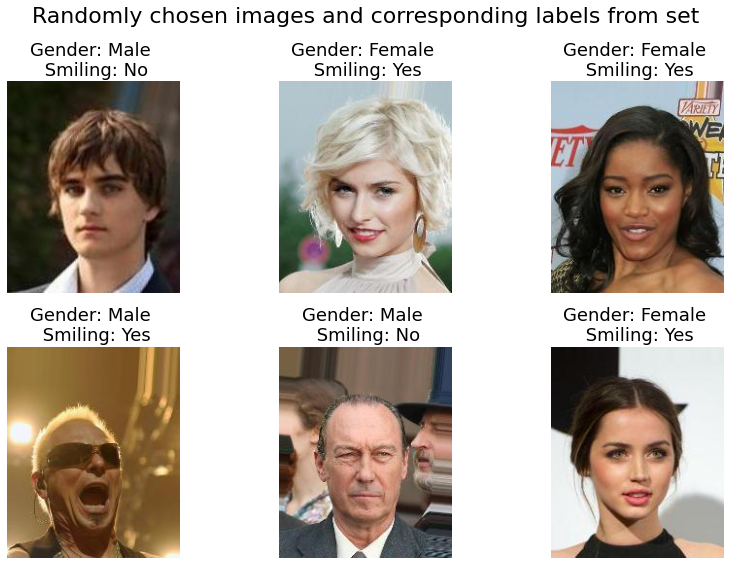

In [2]:
"""
L O A D   D A T A 
"""
# Define a path to the data - REMEMBER TO RESET THIS BEFORE TURNING IN
img_path = "/Users/gardar/Documents/UCL/ELEC0134 MLS-I Applied Machine Learning Systems/Assignments/dataset_AMLS_20-21/celeba/img/"
label_path = "/Users/gardar/Documents/UCL/ELEC0134 MLS-I Applied Machine Learning Systems/Assignments/dataset_AMLS_20-21/celeba/"

# Load image and label data with the novel 'import_data' module
X , y , random_img = ds.dataImport(img_path,label_path,surpress=False,return_img_indices=True)

### Split Data
We'll then split the data into training-, validation- and test folds.

Plotting the dataset split...


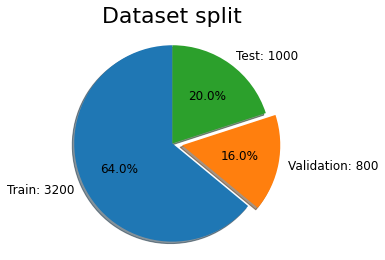

In [3]:
"""
S P L I T   D A T A
"""
    
# Split dataset into train-, validation- and test folds
Xtrain,Xval,Xtest,ytrain,yval,ytest = sd.split_dataset(X,y,test_size=0.2,val_size=0.2,surpress=False)

### Pre-Process Data
Prior to training our classifiers on the data, we perform pre-processing.

In [4]:
from skimage.exposure import equalize_adapthist # To perform Contrast Limited Adaptive Histogram Equalization (CLAHE)
from skimage.color import rgb2gray # For conversion of images to grayscale (my function prints outputs)
from skimage.feature import Cascade # For detecting face boundaries
from skimage.transform import resize # To rescale the extracted faces to a uniform size
from skimage import data # Pre-trained frontal face detection model
from skimage.feature import hog # Histogram of Oriented Gradients feature detector

In [5]:
Xtrain_eq = [equalize_adapthist(img) for img in Xtrain]
Xval_eq = [equalize_adapthist(img) for img in Xval]
Xtest_eq = [equalize_adapthist(img) for img in Xtest]

In [6]:
Xtrain_bw = [rgb2gray(img) for img in Xtrain_eq]
Xval_bw = [rgb2gray(img) for img in Xval_eq]
Xtest_bw = [rgb2gray(img) for img in Xtest_eq]

In [7]:
def find_faces(img_arr,label_data):
    # Load a pre-trained frontal face detection model, that uses Local Binary Patterns
    trained_file = data.lbp_frontal_face_cascade_filename()

    # Initialize the cascade detector
    detector = Cascade(trained_file)
    
    # Initialize variables to store faces and count number of failed instances
    faces = []
    fail_count = 0
    
    # Initialize variable to store the labels, as not all will survive the face detection
    labels = pd.DataFrame([],columns=label_data.columns)

    for i,img in enumerate(img_arr):

        # Detect faces in the data, with adaptive minimum and maximum face boundary sizes
        detected = detector.detect_multi_scale(img=img,
                                               scale_factor=1.1,
                                               step_ratio=1,
                                               min_size=(50, 50),
                                               max_size=(130, 130))

        # The "detected" variable stores the coordinates that frame the face, that is it's basepoints (x,y) or (row,col)
        # and the boundary's width and height

        # We must face the fact that some images may not have detectable faces, for e.g. images of a person's side profile
        # We must hence try to limit the number of these instances, and equalization, grayscaling, and extended
        # flexibility of the detectable boundaries during face recognition are all measures that aim to make the 
        # pre-processing phase less discriminant.
        if not detected: 
            fail_count+=1
            
        else:
            # If a boundary has been found, we extract the coordinates and lengths of the boundary framing the face
            r = detected[0]['r']
            c = detected[0]['c']
            w = detected[0]['width']
            h = detected[0]['height']
            
            # We then extract only the relevant, framed section from the image 
            faces.append(img[r:r+w,c:c+h])
            labels = labels.append(label_data.loc[i])
            
    return faces, fail_count, labels

Extract training data faces

In [8]:
ytrain = ytrain.reset_index()
Xtrain_faces , Xtrain_fail_count, ytrain_labels = find_faces(Xtrain_bw , ytrain)

Extract validation data faces

In [9]:
yval = yval.reset_index()
Xval_faces , Xval_fail_count , yval_labels = find_faces(Xval_bw , yval)

Extract test data faces

In [10]:
ytest = ytest.reset_index()
Xtest_faces , Xtest_fail_count , ytest_labels = find_faces(Xtest_bw , ytest)

In [11]:
def rescale_faces(img_arr,width,height):
    
    # Initalise container for the rescaled image data
    rescaled_faces = []
    
    # For each of the unscaled images
    for img in img_arr:

        # We need to resize the images to ensure that our model is presented with uniform data
        # Examining the sizes of the extracted boundaries, the median size was found to be 104 x 104
        # and average size 103.3 x 103.3. 
        # I hence decide to rescale all the extracted images up or down to 104 x 104 px for fairness.
        # If we are downsampling an image, we perform anti-aliasing, otherwise we don't

        # Verify width of object
        w = img.shape[0]
        
        # If the image is larger than the median value we're scaling down to
        if w > width: 
            # Our image is being downsampled
            downsampling = True
        else:
            # It isn't
            downsampling = False
        
        # Retrieve the rescaled face
        rescaled_face = resize(img,(width,height),anti_aliasing = downsampling)
        
        # Rescale image
        rescaled_faces.append(rescaled_face)
        
    return rescaled_faces

In [12]:
Xtrain_scl = rescale_faces(Xtrain_faces,104,104)

In [13]:
Xval_scl = rescale_faces(Xval_faces,104,104)

In [14]:
Xtest_scl = rescale_faces(Xtest_faces,104,104)

Visualise number of undetectable faces

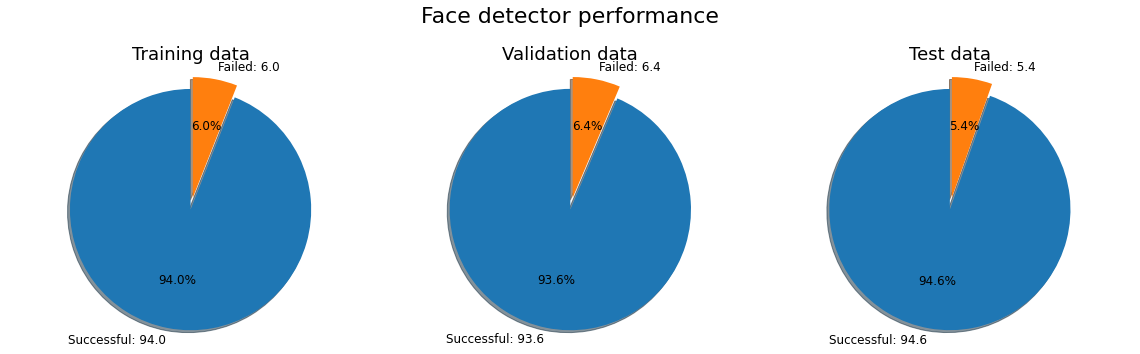

In [15]:
fig,ax = plt.subplots(1,3,figsize=(16,5))

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
explode = (0, 0.1)  # only "explode" the 2nd slice

# TRAINING DATA
successful = (len(Xtrain_faces) / len(Xtrain)) * 100
failed = ((Xtrain_fail_count)/ len(Xtrain)) * 100
sizes = [successful,failed]
labels = ['Successful: {:.1f}'.format(successful),'Failed: {:.1f}'.format(failed)]
ax[0].pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[0].set_title('Training data')

# VALIDATION DATA
successful = (len(Xval_faces) / len(Xval)) * 100
failed = ((Xval_fail_count)/ len(Xval)) * 100
sizes = [successful,failed]
labels = ['Successful: {:.1f}'.format(successful),'Failed: {:.1f}'.format(failed)]
ax[1].pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[1].set_title('Validation data')

# TEST DATA
successful = (len(Xtest_faces) / len(Xtest)) * 100
failed = ((Xtest_fail_count)/ len(Xtest)) * 100
sizes = [successful,failed]
labels = ['Successful: {:.1f}'.format(successful),'Failed: {:.1f}'.format(failed)]
ax[2].pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax[2].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[2].set_title('Test data')

plt.suptitle('Face detector performance')
plt.tight_layout()
plt.show()

In [16]:
def get_hogs(images):
    
    # Containers for HOG descriptors and images
    hog_desc = []
    hog_img = []
    
    for img in images: 
        # Extract hog features and images
        descriptor,image = hog(img, 
                               orientations=8, 
                               pixels_per_cell=(6, 6),
                               cells_per_block=(1, 1), 
                               visualize=True)
        
        # Add the features and images to the containers
        hog_desc.append(descriptor)
        hog_img.append(image)
        
    # Return HOG features and images    
    return hog_desc, hog_img

Extract Histograms of Oriented Gradients from all image date

In [17]:
Xtrain_hogD, Xtrain_hogIMG = get_hogs(Xtrain_scl)

In [18]:
Xval_hogD, Xval_hogIMG = get_hogs(Xval_scl)

In [19]:
Xtest_hogD, Xtest_hogIMG = get_hogs(Xtest_scl)

### Prepare Labels

In [20]:
# The labels are -1 = Female, 1 = Male
# Here, I'm transferring them to the space I € [0...1]
ytrain_A1 = ytrain_labels['gender']#.values[:]
ytrain_A1 = ytrain_A1.astype('int')
ytrain_A1[ytrain_A1<0] = 0

yval_A1 = yval_labels['gender']#.values[:]
yval_A1 = yval_A1.astype('int')
yval_A1[yval_A1<0] = 0

ytest_A1 = ytest_labels['gender']#.values[:]
ytest_A1 = ytest_A1.astype('int')
ytest_A1[ytest_A1<0]=0

# The labels are -1 = Female, 1 = Male
# Here, I'm transferring them to the space I € [0...1]
ytrain_A2 = ytrain_labels['smiling']#.values[:]
ytrain_A2 = ytrain_A2.astype('int')
ytrain_A2[ytrain_A2<0] = 0

yval_A2 = yval_labels['smiling']#.values[:]
yval_A2 = yval_A2.astype('int')
yval_A2[yval_A2<0] = 0

ytest_A2 = ytest_labels['smiling']#.values[:]
ytest_A2 = ytest_A2.astype('int')
ytest_A2[ytest_A2<0]=0

# Classifier: Logistic Regression

In [21]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
import numpy as np

In [22]:
# sklearn functions implementation
def logRegrPredict(Xtrain,ytrain,Xtest, solver='saga'):
    # Build Logistic Regression Model
    logreg = LogisticRegression(solver=solver) # lbfgs solver used for small datasets, 
    # Train the model using the training sets
    logreg.fit(Xtrain, ytrain)
    ypred= logreg.predict(Xtest)
    #print('Accuracy on test set: {:.2f}'.format(logreg.score(x_test, y_test)))
    return ypred

### Validate the performance of different solvers on the tasks

In [23]:
"""
P E R F O R M   L O G I S T I C   R E G R E S S I O N
"""

solvers2try = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']   
A1_LR_Accuracy = []
A2_LR_Accuracy = []

for solver in solvers2try:
    # A1 - Accuracy
    ypred_A1 = logRegrPredict(Xtrain_hogD, ytrain_A1, Xtest_hogD,solver=solver)
    A1_LR_Accuracy.append(accuracy_score(ytest_A1,ypred_A1))

    # A2 - Accuracy
    ypred_A2 = logRegrPredict(Xtrain_hogD, ytrain_A2, Xtest_hogD,solver=solver)
    A2_LR_Accuracy.append(accuracy_score(ytest_A2,ypred_A2))

A1_LR_Accuracy = np.array(A1_LR_Accuracy)    
A2_LR_Accuracy = np.array(A2_LR_Accuracy)

/opt/anaconda3/envs/MLS-I/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/envs/MLS-I/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

In [24]:
pd.DataFrame((A1_LR_Accuracy*100,A2_LR_Accuracy*100),columns=solvers2try, index = ['Task A1','Task A2'])

,liblinear,newton-cg,lbfgs,sag,saga
Task A1,86.786469,85.940803,86.786469,86.680761,86.786469
Task A2,82.135307,82.135307,82.452431,82.346723,83.086681


# Classifier: kNN

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

def KNNClassifier(Xtrain, ytrain, Xtest,k):

    #Create KNN object with a K coefficient
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(Xtrain, ytrain) # Fit KNN model


    ypred = neigh.predict(Xtest)
    return ypred

## Task A1 & Task A2

In [26]:
k_range = np.arange(1,50+1,1)
A1_kNN_Accuracy = []
A2_kNN_Accuracy = []

for k in k_range:
    ypred=KNNClassifier(Xtrain_hogD, ytrain_A1, Xtest_hogD,k)
    A1_kNN_Accuracy.append(metrics.accuracy_score(ytest_A1,ypred))
    
    ypred=KNNClassifier(Xtrain_hogD, ytrain_A2, Xtest_hogD,k)
    A2_kNN_Accuracy.append(metrics.accuracy_score(ytest_A2,ypred))
    
A1_kNN_Accuracy = np.array(A1_kNN_Accuracy)
A2_kNN_Accuracy = np.array(A2_kNN_Accuracy)

KeyboardInterrupt: 

In [ ]:
fig,ax = plt.subplots(2, figsize = (16,10))

ax[0].plot(k_range,A1_kNN_Accuracy,marker='o')

xyMax = {'x': k_range[np.argmax(A1_kNN_Accuracy)], 
         'y': A1_kNN_Accuracy.max()
        }

ax[0].plot(xyMax['x'],xyMax['y'],'ro',markersize=14)
ax[0].annotate("Components: {}\nAccuracy: {:.1f}%".format(xyMax['x'],xyMax['y']*100),(xyMax['x']+4.5,xyMax['y']-0.005))
ax[0].grid("on")
ax[0].set_title("Task A1 - Gender Detection")

ax[1].plot(k_range,A2_kNN_Accuracy,marker='o')

xyMax = {'x': k_range[np.argmax(A2_kNN_Accuracy)], 
         'y': A2_kNN_Accuracy.max()
        }

ax[1].plot(xyMax['x'],xyMax['y'],'ro',markersize=14)
ax[1].annotate("Components: {}\nAccuracy: {:.1f}%".format(xyMax['x'],xyMax['y']*100),(xyMax['x']-4,xyMax['y']-0.025))
ax[1].grid("on")
ax[1].set_title("Task A2 - Smile Detection")

plt.suptitle("HOG with k-Nearest Neighbours")
plt.tight_layout()
fig.set_dpi(800)
plt.show()

# Add PCA to the Processing Pipeline

In [27]:
Xtrain_arr = np.array(Xtrain_hogD)

In [28]:
Xval_arr = np.array(Xval_hogD)

In [29]:
Xtest_arr = np.array(Xtest_hogD)

Performing PCA with Singular Value Decomposition...
Displaying scree plot...


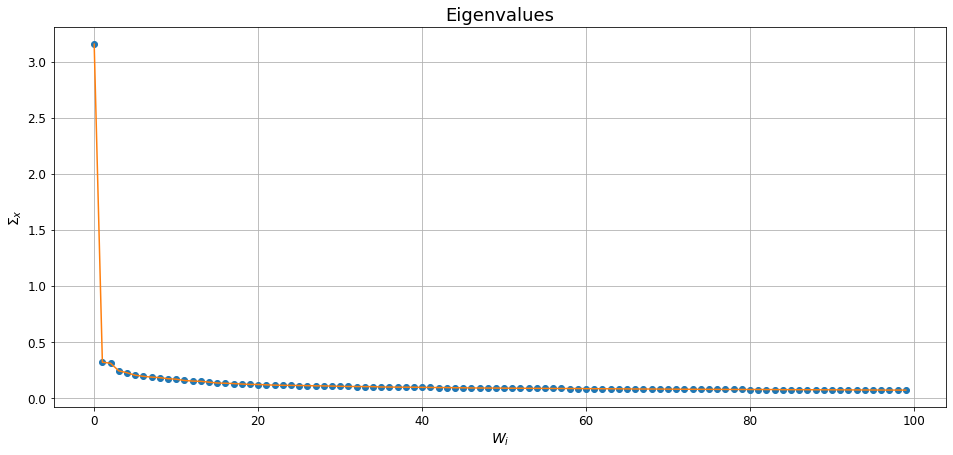

In [30]:
# Perform PCA on test data to obtain eigenvalues and vectors
Sigma,WT = prp.PCA_w_SVD(Xtrain_arr,surpress=False)

In [31]:
"""
F I T   V A L I D A T I O N   A N D   T E S T   T O   P C A 
"""
principalComponents = 50

# Principal components to retain
XtrainPC = prp.fitPCA(WT,Xtrain_hogD,n_components=principalComponents)
XvalPC = prp.fitPCA(WT,Xval_hogD,n_components=principalComponents)
XtestPC = prp.fitPCA(WT,Xtest_hogD,n_components=principalComponents)

Fitting to PCA base
Fitting to PCA base
Fitting to PCA base


# Classifier: SVM

In [32]:
from sklearn import svm

In [33]:
clf = svm.SVC()

In [34]:
A1_SVM_accuracy = 0.
A2_SVM_accuracy = 0.

# Training the decision tree classifier on training set. 
clf.fit(XtrainPC,ytrain_A1)

# Predicting labels on the test set.
ypred_A1 = clf.predict(XtestPC)
A1_SVM_accuracy = (accuracy_score(ytest_A1,ypred_A1))
print('Task A1 - Accuracy score on the test data: {:.1f}%'.format(A1_SVM_accuracy*100))

# Training the decision tree classifier on training set. 
clf.fit(XtrainPC,ytrain_A2)

# Predicting labels on the test set.
ypred_A2 = clf.predict(XtestPC)
A2_SVM_accuracy = (accuracy_score(ytest_A2,ypred_A2))

print('Task A2 - Accuracy score on the test data: {:.1f}%'.format(A2_SVM_accuracy*100))

Task A1 - Accuracy score on the test data: 86.4%
Task A2 - Accuracy score on the test data: 84.7%


### Task A1: Tune Hyper Parameters

In [35]:
from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100,1000],  
              'gamma': [1, 0.1, 0.01, 0.001], 
              'kernel': ['rbf']
             }  
  
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(XtrainPC, ytrain_A1) 

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.508, total=   0.4s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.508, total=   0.4s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.510, total=   0.4s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.510, total=   0.4s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.509, total=   0.4s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.821, total=   0.4s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.789, total=   0.4s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.802, total=   0.4s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.832, total=   0.4s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] .......... C=100, gamma=1, kernel=rbf, score=0.508, total=   0.5s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.508, total=   0.5s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.510, total=   0.5s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.510, total=   0.5s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.509, total=   0.5s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.870, total=   0.4s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.885, total=   0.4s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   34.8s finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']},
             verbose=3)

In [36]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=1, gamma=0.1)


In [37]:
tuned_HP = grid.best_params_

In [38]:
tuned_SVM = svm.SVC(**tuned_HP)

In [39]:
tuned_SVM.fit(XtrainPC, ytrain_A1)

SVC(C=1, gamma=0.1)

In [40]:
ypred = tuned_SVM.predict(XtestPC)

In [41]:
print('Accuracy Score on train data: ', accuracy_score(y_true=ytrain_A1, y_pred=tuned_SVM.predict(XtrainPC)))
print('Accuracy Score on the test data: ', accuracy_score(y_true=ytest_A1, y_pred=ypred))

Accuracy Score on train data:  0.9913592555666334
Accuracy Score on the test data:  0.8784355179704016


In [42]:
# print prediction results 
print(metrics.classification_report(ytest_A1, ypred))

              precision    recall  f1-score   support

           0       0.90      0.85      0.87       469
           1       0.86      0.91      0.88       477

    accuracy                           0.88       946
   macro avg       0.88      0.88      0.88       946
weighted avg       0.88      0.88      0.88       946



### Task A2: Tune Hyper Parameters

In [43]:
clf = svm.SVC()

In [44]:
from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100,1000],  
              'gamma': [1, 0.1, 0.01, 0.001], 
              'kernel': ['rbf']
             } 
  
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(XtrainPC, ytrain_A2) 

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.512, total=   0.4s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.512, total=   0.5s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.512, total=   0.4s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.513, total=   0.4s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.512, total=   0.4s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.769, total=   0.4s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.787, total=   0.4s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.764, total=   0.4s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.754, total=   0.4s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] .......... C=100, gamma=1, kernel=rbf, score=0.512, total=   0.4s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.512, total=   0.5s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.512, total=   0.5s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.513, total=   0.4s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.512, total=   0.4s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.846, total=   0.4s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.827, total=   0.4s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   35.2s finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']},
             verbose=3)

In [45]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=10, gamma=0.01)


In [46]:
tuned_HP = grid.best_params_

In [47]:
tuned_SVM = svm.SVC(**tuned_HP)

In [48]:
tuned_SVM.fit(XtrainPC, ytrain_A2)

SVC(C=10, gamma=0.01)

In [49]:
ypred = tuned_SVM.predict(XtestPC)

In [50]:
print('Accuracy Score on train data: ', accuracy_score(y_true=ytrain_A2, y_pred=tuned_SVM.predict(XtrainPC)))
print('Accuracy Score on the test data: ', accuracy_score(y_true=ytest_A2, y_pred=ypred))

Accuracy Score on train data:  0.9192422731804586
Accuracy Score on the test data:  0.854122621564482


In [51]:
# print prediction results 
print(metrics.classification_report(ytest_A2, ypred))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       439
           1       0.87      0.85      0.86       507

    accuracy                           0.85       946
   macro avg       0.85      0.85      0.85       946
weighted avg       0.85      0.85      0.85       946



After some consideration, I realise I'm on the wrong track here. 
For this specific pre-processing pipeline to work, I must be able to detect faces in every single one of the labeled images fed to the system.
Why you might ask? Well, the thing is that I'm discarding a relatively large portion of the training data, that may seem reasonable if we think of these images as outliers. But what we shouldn't be allowed to do, is to discard labeled images from our validation or test data. In doing so we've actually skewed our accuracy metrics, yes we may acquire +90% accuracy, but not on 100% of the data, only ~94%. <br>
So it's back to the drawing board...